## Week6

In this part, we'll load a pre-trained network and play with it.

In [2]:
from __future__ import print_function
from sys import version_info

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import theano
import theano.tensor as T


try:
    import cPickle as pickle
except ImportError:
    import pickle
    
import lasagne

%matplotlib inline

from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


# Model Zoo (4 pts)
Lasagne has a plethora of pre-training netrworks in the [model zoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo)
* Even more models within the community (neighbor repos, PRs, etc.)


We'll start by picking VGG16 and deploying it in our notebook.

__Warning!__ VGG16 network requires around 3GB of memory to predict event for single-image batch. If you don't have that luxury, try [binder](http://mybinder.org/repo/yandexdataschool/practical_rl) or [azure notebooks](http://notebooks.azure.com/).


In [3]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl -O weights.pkl

--2017-05-08 16:21:37--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.224.227
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.224.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Saving to: 'weights.pkl'

weights.pkl         100%[===================>] 527.82M  15.8MB/s    in 35s     

2017-05-08 16:22:12 (15.1 MB/s) - 'weights.pkl' saved [553459517/553459517]



In [4]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/

from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [5]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl', 'rb'))
#for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, our net won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [6]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    
    img = img[:,:, ::-1]
        
    img = img - MEAN_VALUES
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return floatX(img)

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [7]:
net = build_model()

In [8]:
with open('weights.pkl', 'rb') as f:
    if version_info.major == 2:
        weights = pickle.load(f)
    elif version_info.major == 3:
        weights = pickle.load(f, encoding='latin1')
    
lasagne.layers.set_all_param_values(net["prob"], weights["param values"])

In [14]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net["prob"], input_image, deterministic=True)

prob = theano.function([input_image], output) 

### Sanity check
Let's make sure our network actually works. 

To do so, we'll feed it with some example images.

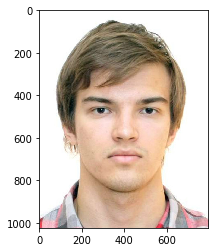

top-5 classes are:
0.168070	Windsor tie
0.134610	lab coat
0.105099	stethoscope
0.091770	suit
0.078189	bow tie


In [120]:
img = imread('sample_images/wIx0ErdTGlY.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(imresize(img,(IMAGE_W,IMAGE_W))))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

##### Ouch!
Try running network 2-3 times. If output changes, then we've probably done something wrong.

Figure out, what's the problem with the network.

_hint_ there are two such 'problematic' layers in vgg16. They're all near the end.

You can make network deterministic by giving it such flag in the `lasagne.layers.get_output` function above.

#### Fun opportunity

ImageNet does not contain any human classes, so if you feed the network with some human photo, it will most likely hallucinate something which is closest to your image.

Try feeding the network with something peculiar: your avatar, Donald Trump, Victor Lempitsky or anyone.

# Grand-quest: Dogs Vs Cats (6 pts)
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [10]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

--2017-05-08 16:22:28--  https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/pojjyvtitjzfy2mjt1LcWTo2XOl6Ng7Nit0d5SJGk1flIgZXLVSUH0CchRhoxom6/file?dl=1 [following]
--2017-05-08 16:22:28--  https://dl.dropboxusercontent.com/content_link/pojjyvtitjzfy2mjt1LcWTo2XOl6Ng7Nit0d5SJGk1flIgZXLVSUH0CchRhoxom6/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: 'data.zip'

data.zip            100%[===================>] 543.16M  39.4MB/s    in 15s     

2017-05-08 16:22:44 (36.3 MB/s) - 'data.zip' saved [56

In [99]:
!wget https://www.dropbox.com/s/am83k0fg1s8ae1d/test1.zip?dl=0 -O test.zip

--2017-05-08 17:19:17--  https://www.dropbox.com/s/am83k0fg1s8ae1d/test1.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/YWAMKlW12x5kMNTrt2cQe4hXk4EwcICZ7ZcqpyPlvWPqwP2t55obbufHmJjJ7l1x/file [following]
--2017-05-08 17:19:17--  https://dl.dropboxusercontent.com/content_link/YWAMKlW12x5kMNTrt2cQe4hXk4EwcICZ7ZcqpyPlvWPqwP2t55obbufHmJjJ7l1x/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284321224 (271M) [application/zip]
Saving to: 'test.zip'

test.zip            100%[===================>] 271.15M  47.6MB/s    in 5.9s    

2017-05-08 17:19:24 (46.3 MB/s) - 'test.zip' saved [284321224/284321224]



# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [15]:
def getLayersFeatures(layer):
    layer_features = lasagne.layers.get_output(net[layer], deterministic=True)
    input_par = net["input"].input_var
    return theano.function([input_par], layer_features)

In [232]:
from tqdm import tqdm_notebook

In [176]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize

X_pred_1 = []
# ids = []
layer = "fc8"
layer_features = lasagne.layers.get_output(net[layer], deterministic=True)
input_par = net["input"].input_var
feature_extract = theano.function([input_par], layer_features)
#this may be a tedious process. If so, store the results in some pickle and re-use them.
i = 0
for fname in tqdm(os.listdir('test1/')):
    y = fname[:-4]
    img = imread("test1/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = feature_extract(img)
#     ids.append(y)
    X_pred_1.append(features)

  0%|          | 28/12500 [00:01<07:23, 28.09it/s]


KeyboardInterrupt: 

In [107]:
X_pred = np.concatenate(X_pred)

In [108]:
np.save("X_pred.npy", X_pred)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [21]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [28]:
from sklearn.metrics import log_loss, auc, accuracy_score

In [90]:
clf = LogisticRegression(penalty="l1", C=0.1)

In [92]:
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
clf.predict_proba(X_test)[:,0]

array([  9.99975107e-01,   9.49859998e-01,   6.29955268e-07, ...,
         6.50611176e-05,   3.75739087e-05,   2.54340016e-01])

In [211]:
log_loss(y_test, clf.predict(X_test))

17.103797812210683

In [119]:
pred = clf.predict_proba(X_pred)[:, 0]

In [120]:
import pandas as pd

In [121]:
result = pd.DataFrame()

In [122]:
result["id"] = ids
result["label"] = pred
result["label"] = result["label"].astype(float)

## score = 0.08339

In [124]:
result.to_csv("result.csv", index=False, float_format='%g')

In [118]:
np.save("Y.pkl",Y)

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [238]:
def get_data():
    images = []
    targets = []
    for fname in tqdm(os.listdir('train/')):
        y = fname.startswith("cat")
        targets.append(y)
        img = imread("train/"+fname)
        img = preprocess(imresize(img, (IMAGE_W, IMAGE_W)))
        images.append(img)
    
    return np.concatenate(images), np.array(targets, dtype='int32')

def read_images(names):
    images = []
    for fname in names:
        img = imread("train/"+fname)
        img = preprocess(imresize(img, (IMAGE_W, IMAGE_W)))
        images.append(img)
    
    return np.concatenate(images)

In [239]:
x_data, y_data = get_data()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=2500, stratify=y_data, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2500, stratify=y_train, random_state=0)







  0%|          | 0/25000 [00:00<?, ?it/s]





  0%|          | 18/25000 [00:00<02:25, 171.25it/s]










  0%|          | 36/25000 [00:00<02:24, 173.22it/s]





  0%|          | 55/25000 [00:00<02:22, 174.85it/s]





  0%|          | 72/25000 [00:00<02:25, 171.31it/s]





  0%|          | 92/25000 [00:00<02:19, 177.94it/s]





  0%|          | 111/25000 [00:00<02:18, 179.20it/s]





  1%|          | 130/25000 [00:00<02:17, 180.58it/s]





  1%|          | 148/25000 [00:00<02:18, 180.08it/s]





  1%|          | 166/25000 [00:00<02:20, 176.76it/s]





  1%|          | 184/25000 [00:01<02:21, 175.10it/s]





  1%|          | 202/25000 [00:01<02:24, 171.34it/s]





  1%|          | 220/25000 [00:01<02:23, 172.35it/s]





  1%|          | 239/25000 [00:01<02:20, 176.39it/s]





  1%|          | 257/25000 [00:01<02:23, 172.38it/s]





  1%|          | 275/25000 [00:01<02:24, 170.98it/s]





  1%|          | 293/25000 [00:01<02:24, 170.41it/s]





  1%|          | 31

  8%|▊         | 1948/25000 [00:11<02:18, 166.71it/s]





  8%|▊         | 1965/25000 [00:11<02:18, 165.88it/s]





  8%|▊         | 1983/25000 [00:11<02:16, 169.23it/s]





  8%|▊         | 2000/25000 [00:11<02:18, 166.42it/s]





  8%|▊         | 2019/25000 [00:11<02:14, 170.90it/s]





  8%|▊         | 2037/25000 [00:11<02:13, 172.07it/s]





  8%|▊         | 2055/25000 [00:11<02:12, 173.58it/s]





  8%|▊         | 2073/25000 [00:11<02:13, 171.74it/s]





  8%|▊         | 2091/25000 [00:12<02:15, 168.76it/s]





  8%|▊         | 2109/25000 [00:12<02:14, 170.10it/s]





  9%|▊         | 2127/25000 [00:12<02:15, 168.82it/s]





  9%|▊         | 2144/25000 [00:12<02:15, 168.36it/s]





  9%|▊         | 2162/25000 [00:12<02:15, 169.15it/s]





  9%|▊         | 2181/25000 [00:12<02:12, 172.56it/s]





  9%|▉         | 2199/25000 [00:12<02:10, 174.17it/s]





  9%|▉         | 2217/25000 [00:12<02:12, 171.86it/s]





  9%|▉         | 2235/25000 [00:12<02:11, 173.56it/s]




 15%|█▌        | 3855/25000 [00:22<01:57, 179.68it/s]





 15%|█▌        | 3873/25000 [00:22<01:59, 176.40it/s]





 16%|█▌        | 3891/25000 [00:22<02:01, 173.46it/s]





 16%|█▌        | 3909/25000 [00:22<02:03, 171.46it/s]





 16%|█▌        | 3927/25000 [00:22<02:01, 173.45it/s]





 16%|█▌        | 3945/25000 [00:22<02:01, 173.53it/s]





 16%|█▌        | 3963/25000 [00:23<02:04, 169.24it/s]





 16%|█▌        | 3981/25000 [00:23<02:03, 170.04it/s]





 16%|█▌        | 3999/25000 [00:23<02:05, 167.02it/s]





 16%|█▌        | 4018/25000 [00:23<02:02, 171.90it/s]





 16%|█▌        | 4036/25000 [00:23<02:03, 170.03it/s]





 16%|█▌        | 4054/25000 [00:23<02:03, 170.10it/s]





 16%|█▋        | 4073/25000 [00:23<01:59, 175.12it/s]





 16%|█▋        | 4091/25000 [00:23<01:58, 176.03it/s]





 16%|█▋        | 4109/25000 [00:23<02:01, 172.34it/s]





 17%|█▋        | 4127/25000 [00:24<02:05, 166.70it/s]





 17%|█▋        | 4145/25000 [00:24<02:03, 168.34it/s]




 23%|██▎       | 5806/25000 [00:33<01:50, 174.42it/s]





 23%|██▎       | 5824/25000 [00:33<01:51, 172.47it/s]





 23%|██▎       | 5842/25000 [00:33<01:55, 165.24it/s]





 23%|██▎       | 5859/25000 [00:33<01:55, 165.92it/s]





 24%|██▎       | 5877/25000 [00:34<01:53, 169.20it/s]





 24%|██▎       | 5896/25000 [00:34<01:50, 172.84it/s]





 24%|██▎       | 5914/25000 [00:34<01:51, 171.77it/s]





 24%|██▎       | 5933/25000 [00:34<01:49, 174.18it/s]





 24%|██▍       | 5951/25000 [00:34<01:49, 174.55it/s]





 24%|██▍       | 5969/25000 [00:34<01:51, 170.85it/s]





 24%|██▍       | 5987/25000 [00:34<01:49, 172.87it/s]





 24%|██▍       | 6005/25000 [00:34<01:49, 173.92it/s]





 24%|██▍       | 6024/25000 [00:34<01:47, 176.96it/s]





 24%|██▍       | 6043/25000 [00:34<01:46, 177.89it/s]





 24%|██▍       | 6061/25000 [00:35<01:47, 176.85it/s]





 24%|██▍       | 6079/25000 [00:35<01:49, 173.09it/s]





 24%|██▍       | 6097/25000 [00:35<01:50, 170.56it/s]




 31%|███       | 7745/25000 [00:44<01:37, 176.18it/s]





 31%|███       | 7764/25000 [00:44<01:37, 177.32it/s]





 31%|███       | 7782/25000 [00:45<01:38, 174.10it/s]





 31%|███       | 7800/25000 [00:45<01:42, 167.65it/s]





 31%|███▏      | 7817/25000 [00:45<01:43, 165.63it/s]





 31%|███▏      | 7835/25000 [00:45<01:42, 167.37it/s]





 31%|███▏      | 7853/25000 [00:45<01:40, 170.80it/s]





 31%|███▏      | 7871/25000 [00:45<01:41, 169.09it/s]





 32%|███▏      | 7888/25000 [00:45<01:43, 166.10it/s]





 32%|███▏      | 7908/25000 [00:45<01:38, 173.85it/s]





 32%|███▏      | 7926/25000 [00:45<01:37, 174.72it/s]





 32%|███▏      | 7944/25000 [00:45<01:38, 172.45it/s]





 32%|███▏      | 7962/25000 [00:46<01:39, 170.97it/s]





 32%|███▏      | 7980/25000 [00:46<01:39, 170.71it/s]





 32%|███▏      | 7999/25000 [00:46<01:37, 174.22it/s]





 32%|███▏      | 8017/25000 [00:46<01:40, 169.72it/s]





 32%|███▏      | 8035/25000 [00:46<01:38, 172.00it/s]




 39%|███▊      | 9656/25000 [00:56<01:29, 171.06it/s]





 39%|███▊      | 9674/25000 [00:56<01:31, 167.01it/s]





 39%|███▉      | 9692/25000 [00:56<01:29, 170.21it/s]





 39%|███▉      | 9710/25000 [00:56<01:30, 168.39it/s]





 39%|███▉      | 9728/25000 [00:56<01:29, 170.23it/s]





 39%|███▉      | 9746/25000 [00:56<01:31, 167.16it/s]





 39%|███▉      | 9763/25000 [00:56<01:32, 165.27it/s]





 39%|███▉      | 9780/25000 [00:56<01:31, 166.58it/s]





 39%|███▉      | 9798/25000 [00:56<01:30, 167.23it/s]





 39%|███▉      | 9815/25000 [00:56<01:31, 166.76it/s]





 39%|███▉      | 9832/25000 [00:57<01:34, 160.99it/s]





 39%|███▉      | 9849/25000 [00:57<01:33, 162.67it/s]





 39%|███▉      | 9866/25000 [00:57<01:32, 162.82it/s]





 40%|███▉      | 9885/25000 [00:57<01:28, 169.87it/s]





 40%|███▉      | 9903/25000 [00:57<01:29, 168.82it/s]





 40%|███▉      | 9921/25000 [00:57<01:29, 168.48it/s]





 40%|███▉      | 9938/25000 [00:57<01:31, 164.95it/s]




 46%|████▌     | 11514/25000 [01:07<01:23, 162.39it/s]





 46%|████▌     | 11531/25000 [01:07<01:23, 161.15it/s]





 46%|████▌     | 11548/25000 [01:07<01:23, 161.19it/s]





 46%|████▋     | 11565/25000 [01:07<01:22, 161.95it/s]





 46%|████▋     | 11582/25000 [01:07<01:23, 161.28it/s]





 46%|████▋     | 11600/25000 [01:07<01:21, 164.87it/s]





 46%|████▋     | 11618/25000 [01:07<01:20, 167.14it/s]





 47%|████▋     | 11635/25000 [01:07<01:21, 164.22it/s]





 47%|████▋     | 11652/25000 [01:07<01:20, 165.11it/s]





 47%|████▋     | 11670/25000 [01:08<01:19, 168.17it/s]





 47%|████▋     | 11689/25000 [01:08<01:17, 172.57it/s]





 47%|████▋     | 11707/25000 [01:08<01:18, 170.01it/s]





 47%|████▋     | 11725/25000 [01:08<01:16, 172.44it/s]





 47%|████▋     | 11743/25000 [01:08<01:17, 170.75it/s]





 47%|████▋     | 11761/25000 [01:08<01:17, 170.67it/s]





 47%|████▋     | 11780/25000 [01:08<01:15, 175.56it/s]





 47%|████▋     | 11798/25000 [01:08<01:1

 53%|█████▎    | 13357/25000 [01:18<01:08, 170.06it/s]





 54%|█████▎    | 13375/25000 [01:18<01:10, 165.21it/s]





 54%|█████▎    | 13392/25000 [01:18<01:11, 163.17it/s]





 54%|█████▎    | 13409/25000 [01:18<01:10, 163.68it/s]





 54%|█████▎    | 13426/25000 [01:18<01:13, 158.24it/s]





 54%|█████▍    | 13442/25000 [01:18<01:14, 154.91it/s]





 54%|█████▍    | 13460/25000 [01:18<01:11, 160.62it/s]





 54%|█████▍    | 13478/25000 [01:18<01:10, 163.17it/s]





 54%|█████▍    | 13495/25000 [01:19<01:10, 162.25it/s]





 54%|█████▍    | 13513/25000 [01:19<01:09, 164.12it/s]





 54%|█████▍    | 13530/25000 [01:19<01:09, 165.53it/s]





 54%|█████▍    | 13549/25000 [01:19<01:06, 170.97it/s]





 54%|█████▍    | 13567/25000 [01:19<01:07, 169.77it/s]





 54%|█████▍    | 13585/25000 [01:19<01:07, 167.96it/s]





 54%|█████▍    | 13602/25000 [01:19<01:08, 165.23it/s]





 54%|█████▍    | 13619/25000 [01:19<01:09, 164.14it/s]





 55%|█████▍    | 13636/25000 [01:19<01:0

 61%|██████    | 15187/25000 [01:29<00:58, 168.39it/s]





 61%|██████    | 15204/25000 [01:29<00:58, 166.79it/s]





 61%|██████    | 15222/25000 [01:29<00:58, 168.30it/s]





 61%|██████    | 15242/25000 [01:29<00:55, 175.08it/s]





 61%|██████    | 15260/25000 [01:29<00:56, 173.88it/s]





 61%|██████    | 15278/25000 [01:29<00:57, 168.72it/s]





 61%|██████    | 15295/25000 [01:29<01:00, 161.53it/s]





 61%|██████▏   | 15313/25000 [01:30<00:58, 165.55it/s]





 61%|██████▏   | 15331/25000 [01:30<00:57, 168.85it/s]





 61%|██████▏   | 15348/25000 [01:30<00:57, 168.97it/s]





 61%|██████▏   | 15367/25000 [01:30<00:55, 172.99it/s]





 62%|██████▏   | 15385/25000 [01:30<00:56, 169.47it/s]





 62%|██████▏   | 15403/25000 [01:30<00:57, 166.44it/s]





 62%|██████▏   | 15420/25000 [01:30<00:57, 166.60it/s]





 62%|██████▏   | 15437/25000 [01:30<00:57, 166.14it/s]





 62%|██████▏   | 15455/25000 [01:30<00:57, 166.97it/s]





 62%|██████▏   | 15472/25000 [01:30<00:5

 68%|██████▊   | 17022/25000 [01:40<00:48, 165.19it/s]





 68%|██████▊   | 17039/25000 [01:40<00:47, 166.42it/s]





 68%|██████▊   | 17057/25000 [01:40<00:47, 168.17it/s]





 68%|██████▊   | 17075/25000 [01:40<00:46, 170.00it/s]





 68%|██████▊   | 17093/25000 [01:40<00:46, 168.90it/s]





 68%|██████▊   | 17110/25000 [01:40<00:47, 166.30it/s]





 69%|██████▊   | 17127/25000 [01:40<00:47, 164.59it/s]





 69%|██████▊   | 17145/25000 [01:41<00:46, 167.46it/s]





 69%|██████▊   | 17162/25000 [01:41<00:47, 165.50it/s]





 69%|██████▊   | 17181/25000 [01:41<00:46, 169.72it/s]





 69%|██████▉   | 17199/25000 [01:41<00:45, 171.90it/s]





 69%|██████▉   | 17217/25000 [01:41<00:46, 167.66it/s]





 69%|██████▉   | 17234/25000 [01:41<00:46, 168.17it/s]





 69%|██████▉   | 17251/25000 [01:41<00:46, 167.29it/s]





 69%|██████▉   | 17268/25000 [01:41<00:46, 167.27it/s]





 69%|██████▉   | 17285/25000 [01:41<00:47, 162.85it/s]





 69%|██████▉   | 17303/25000 [01:42<00:4

 75%|███████▌  | 18852/25000 [01:51<00:36, 166.24it/s]





 75%|███████▌  | 18869/25000 [01:51<00:36, 167.07it/s]





 76%|███████▌  | 18887/25000 [01:51<00:36, 169.21it/s]





 76%|███████▌  | 18905/25000 [01:51<00:35, 171.18it/s]





 76%|███████▌  | 18923/25000 [01:51<00:35, 169.56it/s]





 76%|███████▌  | 18940/25000 [01:51<00:35, 169.44it/s]





 76%|███████▌  | 18957/25000 [01:51<00:35, 168.75it/s]





 76%|███████▌  | 18974/25000 [01:52<00:36, 166.46it/s]





 76%|███████▌  | 18991/25000 [01:52<00:36, 164.52it/s]





 76%|███████▌  | 19008/25000 [01:52<00:36, 164.14it/s]





 76%|███████▌  | 19026/25000 [01:52<00:35, 167.06it/s]





 76%|███████▌  | 19043/25000 [01:52<00:35, 167.08it/s]





 76%|███████▌  | 19060/25000 [01:52<00:35, 165.83it/s]





 76%|███████▋  | 19078/25000 [01:52<00:35, 168.41it/s]





 76%|███████▋  | 19095/25000 [01:52<00:35, 166.12it/s]





 76%|███████▋  | 19113/25000 [01:52<00:34, 169.40it/s]





 77%|███████▋  | 19130/25000 [01:53<00:3

 83%|████████▎ | 20687/25000 [02:02<00:26, 163.80it/s]





 83%|████████▎ | 20705/25000 [02:02<00:25, 166.41it/s]





 83%|████████▎ | 20722/25000 [02:02<00:25, 164.88it/s]





 83%|████████▎ | 20739/25000 [02:02<00:25, 165.76it/s]





 83%|████████▎ | 20757/25000 [02:02<00:25, 168.73it/s]





 83%|████████▎ | 20774/25000 [02:02<00:25, 168.68it/s]





 83%|████████▎ | 20791/25000 [02:02<00:25, 166.34it/s]





 83%|████████▎ | 20808/25000 [02:03<00:25, 166.08it/s]





 83%|████████▎ | 20825/25000 [02:03<00:25, 165.57it/s]





 83%|████████▎ | 20843/25000 [02:03<00:24, 168.41it/s]





 83%|████████▎ | 20860/25000 [02:03<00:24, 167.03it/s]





 84%|████████▎ | 20877/25000 [02:03<00:24, 167.06it/s]





 84%|████████▎ | 20894/25000 [02:03<00:25, 161.33it/s]





 84%|████████▎ | 20912/25000 [02:03<00:24, 164.23it/s]





 84%|████████▎ | 20929/25000 [02:03<00:25, 162.31it/s]





 84%|████████▍ | 20948/25000 [02:03<00:24, 166.65it/s]





 84%|████████▍ | 20965/25000 [02:04<00:2

 90%|█████████ | 22511/25000 [02:13<00:15, 164.82it/s]





 90%|█████████ | 22529/25000 [02:13<00:14, 168.65it/s]





 90%|█████████ | 22548/25000 [02:13<00:14, 173.98it/s]





 90%|█████████ | 22566/25000 [02:13<00:14, 170.12it/s]





 90%|█████████ | 22584/25000 [02:13<00:14, 168.60it/s]





 90%|█████████ | 22601/25000 [02:13<00:14, 164.16it/s]





 90%|█████████ | 22618/25000 [02:14<00:14, 159.11it/s]





 91%|█████████ | 22634/25000 [02:14<00:14, 158.29it/s]





 91%|█████████ | 22651/25000 [02:14<00:14, 161.00it/s]





 91%|█████████ | 22668/25000 [02:14<00:14, 161.22it/s]





 91%|█████████ | 22685/25000 [02:14<00:14, 162.27it/s]





 91%|█████████ | 22702/25000 [02:14<00:14, 161.52it/s]





 91%|█████████ | 22719/25000 [02:14<00:14, 160.15it/s]





 91%|█████████ | 22737/25000 [02:14<00:13, 163.85it/s]





 91%|█████████ | 22754/25000 [02:14<00:13, 164.91it/s]





 91%|█████████ | 22771/25000 [02:15<00:13, 160.98it/s]





 91%|█████████ | 22788/25000 [02:15<00:1

 97%|█████████▋| 24339/25000 [02:24<00:03, 166.67it/s]





 97%|█████████▋| 24356/25000 [02:24<00:03, 166.35it/s]





 97%|█████████▋| 24373/25000 [02:24<00:03, 166.32it/s]





 98%|█████████▊| 24390/25000 [02:24<00:03, 164.56it/s]





 98%|█████████▊| 24407/25000 [02:24<00:03, 164.56it/s]





 98%|█████████▊| 24425/25000 [02:25<00:03, 166.67it/s]





 98%|█████████▊| 24443/25000 [02:25<00:03, 167.71it/s]





 98%|█████████▊| 24460/25000 [02:25<00:03, 167.88it/s]





 98%|█████████▊| 24477/25000 [02:25<00:03, 164.98it/s]





 98%|█████████▊| 24494/25000 [02:25<00:03, 163.93it/s]





 98%|█████████▊| 24512/25000 [02:25<00:02, 166.02it/s]





 98%|█████████▊| 24529/25000 [02:25<00:02, 164.98it/s]





 98%|█████████▊| 24546/25000 [02:25<00:02, 163.12it/s]





 98%|█████████▊| 24563/25000 [02:25<00:02, 162.13it/s]





 98%|█████████▊| 24580/25000 [02:25<00:02, 163.52it/s]





 98%|█████████▊| 24597/25000 [02:26<00:02, 162.38it/s]





 98%|█████████▊| 24614/25000 [02:26<00:0

In [300]:
from lasagne.nonlinearities import rectify, sigmoid

In [301]:
input_image = T.tensor4('input')
targets = T.ivector('targets')

In [302]:
net['new_fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=rectify)
net['new_proba'] = DenseLayer(net['new_fc8'], num_units=1, nonlinearity=sigmoid)

In [303]:
old_params = lasagne.layers.get_all_params(net['fc7'], trainable=True)
params = [p for p in lasagne.layers.get_all_params(net['new_proba'], trainable=True)
         if p not in old_params]
output = lasagne.layers.get_output(net['new_proba'], input_image, deterministic=True)
loss_train = lasagne.objectives.binary_crossentropy(output, targets).mean()
loss_val = lasagne.objectives.binary_crossentropy(output, targets).mean()

update = lasagne.updates.adam(loss_train, params)
train_func = theano.function(inputs=[input_image, targets], outputs=loss_train, updates=update)
val_func = theano.function(inputs=[input_image, targets], outputs=loss_val)

In [304]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):    
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        yield inputs[excerpt], targets[excerpt]

In [305]:
n_epoch = 2
batch_size = 125;

for i in tqdm(range(n_epoch)):
    train_err = 0
    train_batches = 0
    for index, batch in enumerate(iterate_minibatches(x_train, y_train, batch_size, shuffle=True)):
        inputs, targets = batch
        err = train_func(inputs, targets)
        print("{} train loss = {}" .format(index, err))
        train_err += err
        train_batches += 1
        
    val_err = 0
    val_batches = 0
    for batch in iterate_minibatches(x_val, y_val, batch_size, shuffle=False):
        inputs, targets = batch
        err = val_func(inputs, targets)
        print("val loss = {}" .format(err))
        val_err += err
        val_batches += 1
        
    print("epoch {0}: train loss = {1}, val loss = {2}" .format(i, train_err / train_batches, val_err / val_batches))

  0%|          | 0/2 [00:00<?, ?it/s]

0 train loss = 1.30997494489
1 train loss = 7.31465316653
2 train loss = 1.66110845903
3 train loss = 0.327486023579
4 train loss = 0.228511387192
5 train loss = 0.931501904441
6 train loss = 1.6964471172
7 train loss = 0.477195096664
8 train loss = 0.415867487992
9 train loss = 0.21312079528
10 train loss = 0.488778333222
11 train loss = 0.216156779582
12 train loss = 0.0552454389941
13 train loss = 0.130386443545
14 train loss = 0.0508821309214
15 train loss = 0.044309743874
16 train loss = 0.0537433632751
17 train loss = 0.0904071375703
18 train loss = 0.0975747972892
19 train loss = 0.191427654107
20 train loss = 0.0683282417304
21 train loss = 0.173035632
22 train loss = 0.19173223237
23 train loss = 0.020063983483
24 train loss = 0.0467986511776
25 train loss = 0.0933986833154
26 train loss = 0.0527076975987
27 train loss = 0.036860870151
28 train loss = 0.0340906247952
29 train loss = 0.0714160221432
30 train loss = 0.0434277690138
31 train loss = 0.0179560489511
32 train loss =

 50%|█████     | 1/2 [07:34<07:34, 454.19s/it]

val loss = 0.0678431402091
epoch 0: train loss = 0.143626216349, val loss = 0.0338887996122
0 train loss = 0.0405236486793
1 train loss = 0.0328259507828
2 train loss = 0.0315639802076
3 train loss = 0.0477530131857
4 train loss = 0.0230981931277
5 train loss = 0.0985941113975
6 train loss = 0.0224530562994
7 train loss = 0.0684470783909
8 train loss = 0.0133143605185
9 train loss = 0.0127592672073
10 train loss = 0.0233314105383
11 train loss = 0.0124506131719
12 train loss = 0.0101549369565
13 train loss = 0.0129654358709
14 train loss = 0.0303029114283
15 train loss = 0.0880957861651
16 train loss = 0.0316748276925
17 train loss = 0.0510840566029
18 train loss = 0.0170707271277
19 train loss = 0.0303013972737
20 train loss = 0.00940952769425
21 train loss = 0.0148685471261
22 train loss = 0.00663883672783
23 train loss = 0.0663658948703
24 train loss = 0.0359229594653
25 train loss = 0.0232079288095
26 train loss = 0.0129315146825
27 train loss = 0.015459034135
28 train loss = 0.021

100%|██████████| 2/2 [15:10<00:00, 454.73s/it]

val loss = 0.0812194772018
epoch 1: train loss = 0.0310717589196, val loss = 0.0328710166736


In [306]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize

X_pred_1 = []
ids = []
layer = "new_proba"
layer_ouput_new = lasagne.layers.get_output(net[layer], deterministic=True)
input_par = net["input"].input_var
output_prob = theano.function([input_par], layer_ouput_new)
#this may be a tedious process. If so, store the results in some pickle and re-use them.
i = 0
for fname in tqdm(os.listdir('test1/')):
    y = fname[:-4]
    img = imread("test1/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    prob = output_prob(img)
    ids.append(y)
    X_pred_1.append(prob[0][0])

100%|██████████| 12500/12500 [07:09<00:00, 29.09it/s]


In [307]:
X_pred_1

[1.0,
 0.99065793,
 1.0152206e-08,
 1.0,
 5.2186024e-06,
 0.87905508,
 0.99999928,
 4.0555886e-07,
 0.99999547,
 5.8875713e-09,
 0.99998176,
 1.0,
 1.0,
 7.4147656e-06,
 1.6110629e-08,
 7.3657752e-06,
 1.0,
 0.99999821,
 0.99220473,
 2.3273538e-08,
 3.7121179e-06,
 0.99999571,
 0.00022577855,
 1.0,
 1.0,
 1.0,
 0.80499119,
 3.8318831e-05,
 1.0,
 0.00070130837,
 1.0,
 1.0,
 3.6376153e-07,
 0.00017176355,
 0.37532949,
 0.019167937,
 0.00022854439,
 1.0,
 1.0,
 0.0026982785,
 1.0,
 1.0866842e-09,
 5.348531e-09,
 9.5375285e-10,
 1.0,
 1.0,
 0.00023868526,
 0.49963072,
 0.65239018,
 1.0,
 6.651383e-06,
 5.4262256e-07,
 1.0,
 1.0,
 2.9543492e-06,
 1.0,
 3.9451313e-15,
 4.6747637e-16,
 3.9818686e-09,
 9.5987207e-06,
 5.9505756e-10,
 0.85273468,
 5.7678972e-07,
 1.0,
 1.886735e-11,
 1.9988113e-07,
 0.00050761818,
 1.0,
 0.14276965,
 1.7399541e-06,
 1.0855384e-05,
 0.60602736,
 1.2426893e-05,
 1.0,
 4.6912896e-07,
 1.3264059e-06,
 0.99977535,
 0.99990439,
 1.9001852e-06,
 0.00011821484,
 3.0864

In [308]:
result_neurons = pd.DataFrame()
result_neurons["id"] = ids
result_neurons["label"] = X_pred_1
result_neurons["label"] = result_neurons["label"].astype(float)
result_neurons["label"] = 1 - result_neurons["label"]

In [309]:
result_neurons

,id,label
0,2790,0.000000e+00
1,5359,9.342074e-03
2,5604,1.000000e+00
3,4440,0.000000e+00
4,7475,9.999948e-01
5,9173,1.209449e-01
6,8451,7.152557e-07
7,3018,9.999996e-01
8,123,4.529953e-06
9,2774,1.000000e+00


In [310]:
result_neurons.to_csv("result_n.csv", index=False, float_format='%g')